In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from tqdm import tqdm

In [2]:
!mkdir -p ~/.kaggle
!cp /kaggle/input/kagglejson/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat '/kaggle/input/kagglejson/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
!pip install kaggle

In [4]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset -p /kaggle/working

Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors
 99% 2.68G/2.70G [00:32<00:00, 196MB/s]
100% 2.70G/2.70G [00:32<00:00, 89.5MB/s]


In [5]:
%%capture
!unzip /kaggle/working/new-plant-diseases-dataset.zip -d /kaggle/working

In [6]:
def check_image_dimensions(folder_path):
    """
    Checks if all images in a folder and its subfolders have the same dimensions.

    :param folder_path: Path to the main folder
    :return: True if all images have the same dimensions, otherwise False and the inconsistent dimensions
    """
    dimensions = None
    inconsistent_files = []
    total_files = sum(len(files) for _, _, files in os.walk(folder_path))  # Count all files

    # Traverse the folder and its subfolders
    with tqdm(total=total_files, desc="Processing images", unit="file") as pbar:
        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                try:
                    # Open the image file
                    with Image.open(file_path) as img:
                        img_dimensions = img.size  # Returns (width, height)
                        if dimensions is None:
                            # Set the reference dimensions
                            dimensions = img_dimensions
                        elif img_dimensions != dimensions:
                            # Add to the list of inconsistent files if dimensions don't match
                            idnconsistent_files.append((file_path, img_dimensions))
                except Exception as e:
                    # Handle errors when processing non-image files or corrupted images
                    print(f"Error processing {file_path}: {e}")
                finally:
                    pbar.update(1)  # Update the progress bar

    if inconsistent_files:
        # Print all files with inconsistent dimensions
        print("The following images have inconsistent dimensions:")
        for file_path, dim in inconsistent_files:
            print(f"{file_path} - Dimensions: {dim}")
        return False
    else:
        # Print success message if all dimensions are consistent
        print("All images have the same dimensions:", dimensions)
        return True

# Specify the main folder to check
folder_path = "/kaggle/working/"
check_image_dimensions(folder_path)

Processing images:   0%|          | 631/175768 [00:00<01:11, 2444.13file/s]

Error processing /kaggle/working/new-plant-diseases-dataset.zip: cannot identify image file '/kaggle/working/new-plant-diseases-dataset.zip'


Processing images: 100%|██████████| 175768/175768 [00:29<00:00, 5893.76file/s]

All images have the same dimensions: (256, 256)


True

In [7]:
# Configuration of the image data generators
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalization: scales pixel values between 0 and 1
    rotation_range=20,  # Random rotation up to 20 degrees
    width_shift_range=0.2,  # Random horizontal shift up to 20% of the width
    height_shift_range=0.2,  # Random vertical shift up to 20% of the height
    zoom_range=0.2,  # Random zoom up to 20%
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'  # Filling missing pixels with the nearest value
)

# Generator for the validation or test set (without augmentation)
validation_datagen = ImageDataGenerator(rescale=1.0 / 255.0)  # Only normalization

# Load images from the file system
train_generator = train_datagen.flow_from_directory(
    "/kaggle/working/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train",  # Path to the training dataset
    target_size=(256, 256),  # Resize images to 224x224
    batch_size=32,  # Number of images per batch
    class_mode='categorical' , # Type of labels: 'categorical' for multi-class classification
    shuffle=True
)

valid_generator = validation_datagen.flow_from_directory(
    "/kaggle/working/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid",
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

print("Dictionary containing classes:")
print(train_generator.class_indices)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
Dictionary containing classes:
{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Str

In [8]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Function to load and evaluate a model
def load_and_evaluate_model(model_path, test_generator):
    # Load the model
    model = load_model(model_path)
    print(f"Evaluando modelo: {model_path}")

    # Make predictions
    test_generator.reset()
    predictions = model.predict(test_generator, verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes  # Get the real labels
    class_labels = list(test_generator.class_indices.keys())  # Class labels

    return predicted_classes, true_classes, class_labels

# Setting up the generator for raw images
test_generator = validation_datagen.flow_from_directory(
    directory="/kaggle/working/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid",
    target_size=(256, 256),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

# Evaluate the Model 1
predicted_classes1, true_classes1, class_labels1 = load_and_evaluate_model(
    'final_improved_model20,128,1e-5.h5', test_generator
)

# Evaluate the Model 2
predicted_classes2, true_classes2, class_labels2 = load_and_evaluate_model(
    'final_improved_model10+10,128.h5', test_generator
)
# Evaluate the Model 4
predicted_classes4, true_classes4, class_labels4 = load_and_evaluate_model(
    'final_model20+20_128_1e-5.h5', test_generator
)

# Evaluate the Model 5
predicted_classes5, true_classes5, class_labels5 = load_and_evaluate_model(
    'improved20+20_128_1e-5.h5', test_generator
)



Found 17572 images belonging to 38 classes.


Evaluando modelo: final_improved_model20,128,1e-5.h5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


550/550 ━━━━━━━━━━━━━━━━━━━━ 825s 1s/step


Evaluando modelo: final_improved_model10+10,128.h5
550/550 ━━━━━━━━━━━━━━━━━━━━ 1204s 2s/step


Evaluando modelo: final_model20+20_128_1e-5.h5
407/550 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step

KeyboardInterrupt: 

In [ ]:
#CLASSIFICATION REPORT

from sklearn.metrics import classification_report

def print_classification_report(model_name, true_classes, predicted_classes, class_labels):
    # Print the classification report with model name
    print(f"\nClassification Report for {model_name}:\n")
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(report)

# Print the Classification Report for Model 1
print_classification_report("Model 1", true_classes1, predicted_classes1, class_labels1)

# Print the Classification Report for Model 2
print_classification_report("Model 2", true_classes2, predicted_classes2, class_labels2)

# Print the Classification Report for Model 4
print_classification_report("Model 4", true_classes4, predicted_classes4, class_labels4)

# Print the Classification Report for Model 5
print_classification_report("Model 5", true_classes5, predicted_classes5, class_labels5)


Classification Report for Model 1:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.88      0.44      0.59       504
                                 Apple___Black_rot       0.65      0.48      0.55       497
                          Apple___Cedar_apple_rust       0.92      0.66      0.77       440
                                   Apple___healthy       0.71      0.74      0.73       502
                               Blueberry___healthy       0.80      0.63      0.70       454
          Cherry_(including_sour)___Powdery_mildew       0.86      0.81      0.83       421
                 Cherry_(including_sour)___healthy       0.89      0.71      0.79       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.65      0.56      0.60       410
                       Corn_(maize)___Common_rust_       0.99      0.86      0.92       477
               Corn_(maize)___Northern_Lea

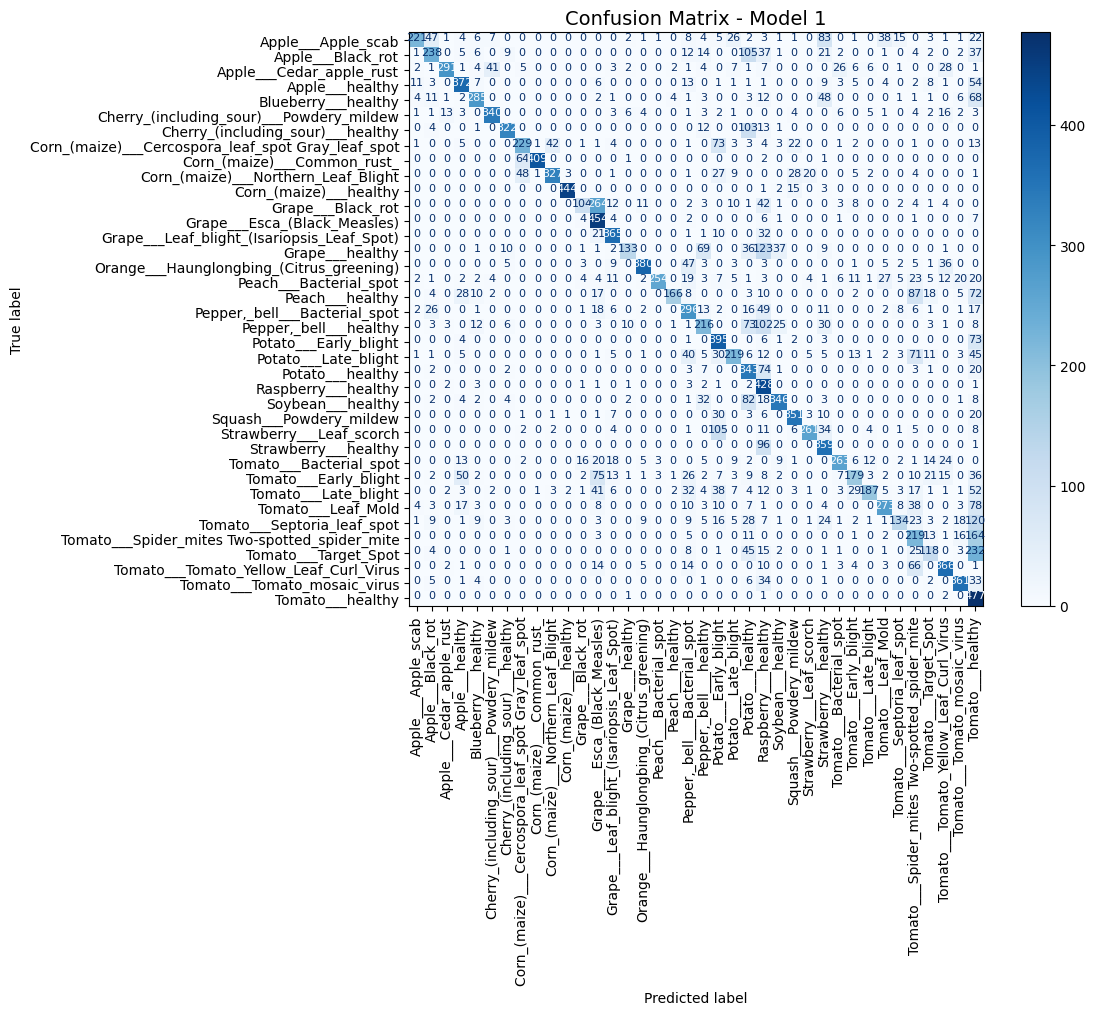

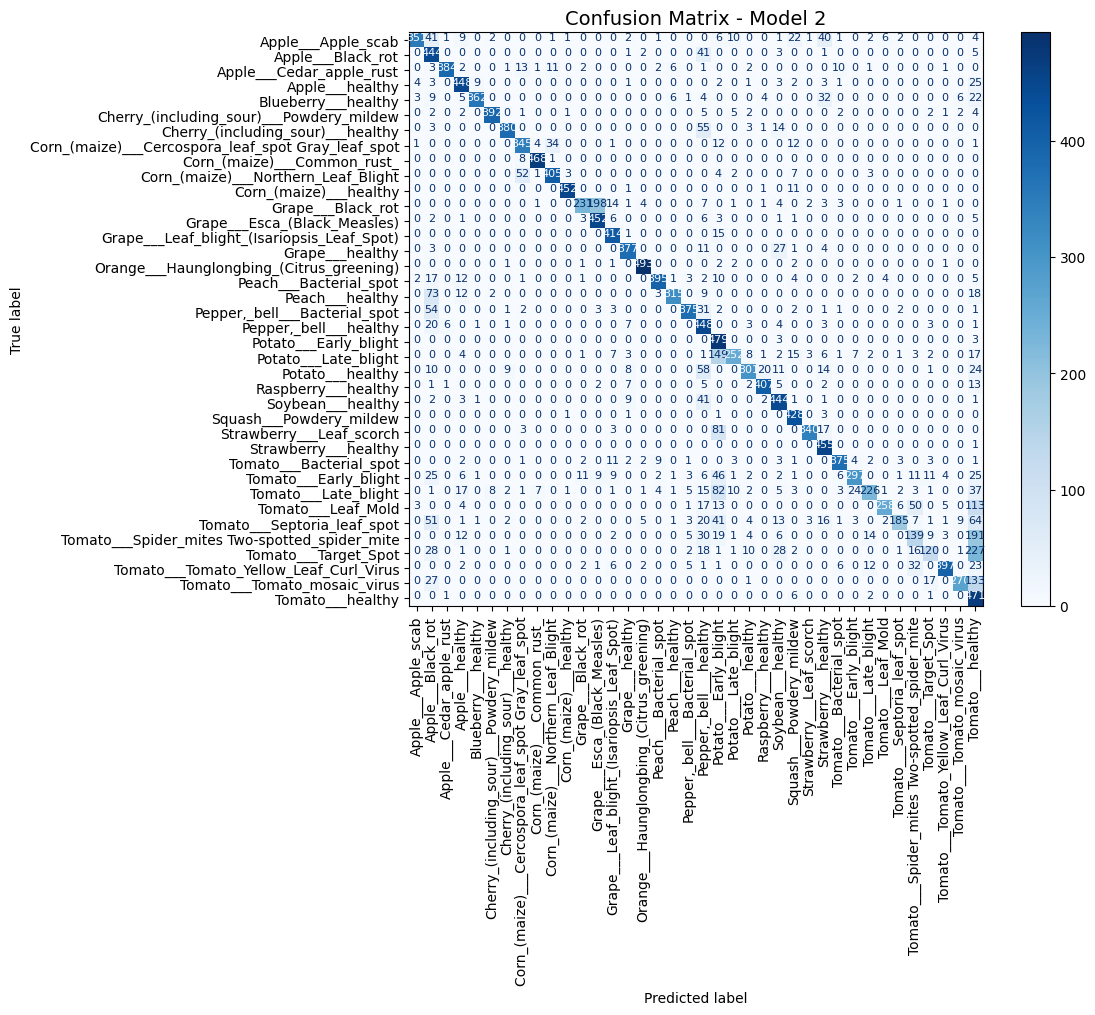

In [ ]:
#CONFUSION MATRIX

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_and_metrics(true_classes, predicted_classes, class_labels, title="Confusion Matrix"):
    # Calculate the confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes, labels=range(len(class_labels)))

    # Adjust figure size to avoid clutter
    fig, ax = plt.subplots(figsize=(12, 10))  # Larger figure size for more space

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=True)

    # Adjust label rotation and size
    ax.set_xticklabels(class_labels, rotation=90, fontsize=10, ha='center')  # Vertical labels
    ax.set_yticklabels(class_labels, fontsize=10)

    # Adjust text size and spacing inside the matrix
    for text in ax.texts:
        text.set_fontsize(8)       # Adjust font size
        text.set_ha('center')     # Center align
        text.set_va('center')     # Vertical align
        text.set_position((text.get_position()[0], text.get_position()[1] - 0.2))  # Adjust spacing

    # Add title to the plot
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Plot results for Model 1
plot_confusion_and_metrics(true_classes1, predicted_classes1, class_labels1, title="Confusion Matrix - Model 1")

# Plot results for Model 2
plot_confusion_and_metrics(true_classes2, predicted_classes2, class_labels2, title="Confusion Matrix - Model 2")

# Plot results for Model 4
plot_confusion_and_metrics(true_classes4, predicted_classes4, class_labels4, title="Confusion Matrix - Model 4")

# Plot results for Model 5
plot_confusion_and_metrics(true_classes5, predicted_classes5, class_labels5, title="Confusion Matrix - Model 5")




In [ ]:
# ROC and AUC Curves

from tensorflow.keras.models import load_model
from sklearn.preprocessing import label_binarize

def get_predicted_probabilities(model_path, test_generator):
    # Load the model
    model = load_model(model_path)

    # Reset the generator and get the predicted probabilities
    test_generator.reset()
    predicted_probabilities = model.predict(test_generator, verbose=1)
    return predicted_probabilities

# Obtaining the probabilities for Model 1
predicted_probabilities1 = get_predicted_probabilities('final_improved_model20,128,1e-5.h5', test_generator)

# Obtaining the probabilities for Model 2
predicted_probabilities2 = get_predicted_probabilities('final_improved_model10+10,128.h5', test_generator)

# Obtaining the probabilities for Model 4
predicted_probabilities4 = get_predicted_probabilities('final_model20+20_128_1e-5.h5', test_generator)

# Obtaining the probabilities for Model 5
predicted_probabilities5 = get_predicted_probabilities('improved20+20_128_1e-5.h5', test_generator)

550/550 ━━━━━━━━━━━━━━━━━━━━ 810s 1s/step


550/550 ━━━━━━━━━━━━━━━━━━━━ 1216s 2s/step


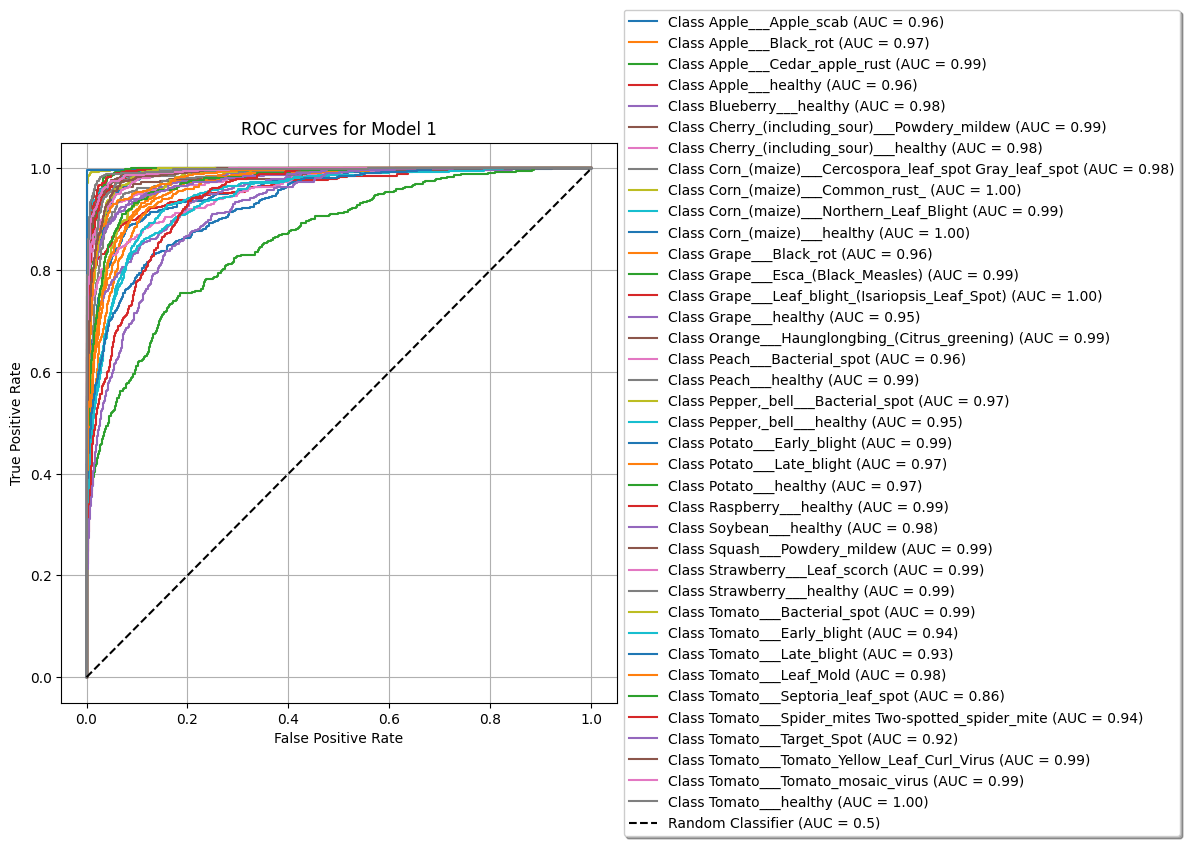

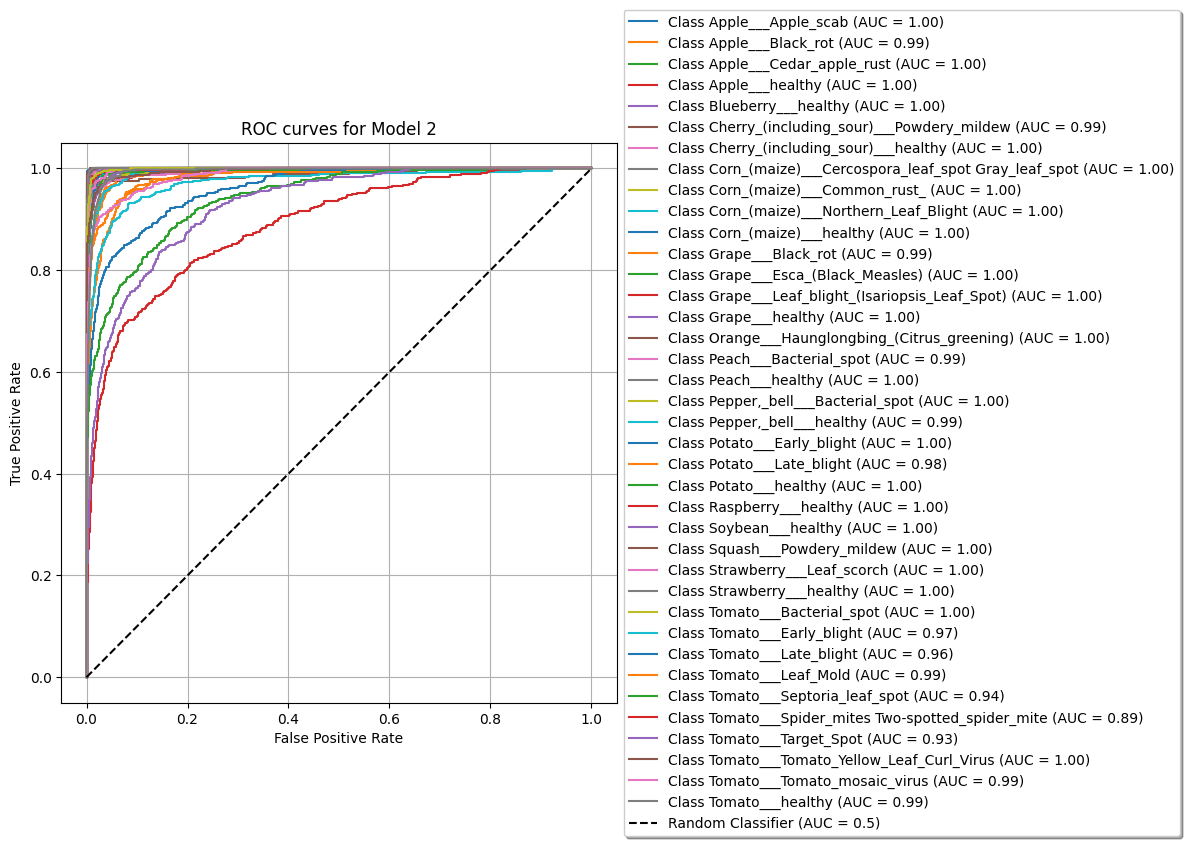

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc_curve(true_classes, predicted_probabilities, class_labels, model_name):
    # Convert true classes to binary format (One-Hot Encoding)
    true_classes_bin = label_binarize(true_classes, classes=range(len(class_labels)))

    # Initialize the figure for the graph
    plt.figure(figsize=(12, 8))

    # Plot the ROC curve for each class
    for i in range(len(class_labels)):
        fpr, tpr, thresholds = roc_curve(true_classes_bin[:, i], predicted_probabilities[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_labels[i]} (AUC = {roc_auc:.2f})')

    # Random ROC curve (diagonal line)
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)')

    # Final adjustments to the chart
    plt.title(f'ROC curves for {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)

    # Place the legend outside the graph to avoid overlaps
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True, ncol=1)

    # Adjust the layout so that the labels do not overlap
    plt.tight_layout()
    plt.show()

#  Plot the ROC and AUC Curves for Model 1
plot_roc_curve(true_classes1, predicted_probabilities1, class_labels1, model_name="Model 1")

# Plot the ROC and AUC Curves for Model 2
plot_roc_curve(true_classes2, predicted_probabilities2, class_labels2, model_name="Model 2")

# Plot the ROC and AUC Curves for Model 4
plot_roc_curve(true_classes4, predicted_probabilities4, class_labels4, model_name="Model 4")

# Plot the ROC and AUC Curves for Model 5
plot_roc_curve(true_classes5, predicted_probabilities5, class_labels5, model_name="Model 5")

